In [1]:
# load env variables from .env file
import dotenv
dotenv.load_dotenv()

True

In [3]:
"""
agents_graph_simple.py
─────────────────────────────────────────────────────────────────
Hub‑and‑spoke agent graph for controlling a robot.
Planner (hub) decides the next specialist (spoke) step.
Specialists never talk to each other—only to the planner.
This is a trimmed‑down, self‑contained version of your original
script that compiles and keeps the same behaviour.
"""
from __future__ import annotations

import json, re
from dataclasses import dataclass, field
from typing import List, Dict, Any, Literal

from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage
from langchain_core.tools import tool

In [45]:
# 1. SYSTEM PROMPTS
# ────────────────────────────────────────────────────────────────
PLANNER_PROMPT = """You are the PLANNER in charge of orchestrating a robot with four
specialists: vision, manipulation and conversation.
Figure out a short ordered python list of steps (JSON only!) that the robot
must execute to complete the user request.
Return ONLY a python array
Example:
[
  {"agent": "vision",       "command": "locate the banana",          "parallel": false},
  {"agent": "manipulation", "command": "pick up the banana",           "parallel": false},
  {"agent": "conversation", "command": "tell the user the job is done","parallel": false}
]

Remember to output a python list, otherwise the robot won't understand it.
"""

VISION_PROMPT = "You are the VISION specialist. Use vision tools only to locate objects."
MANIP_PROMPT  = "You are the MANIPULATION specialist. Pick up or drop items."
CONV_PROMPT   = "You are the CONVERSATION specialist. Speak with the human only. You can only pick one tool at a time."

In [47]:
# 2. SHARED GRAPH STATE
# ────────────────────────────────────────────────────────────────
@dataclass
class AgentState:
    """Everything nodes need to know is in here."""
    messages: List[Any] = field(default_factory=list)          # full chat history
    plan:     List[Dict[str, Any]] = field(default_factory=list)  # remaining steps
    current:  Dict[str, Any] | None = None                     # step in progress
    results:  List[str] = field(default_factory=list)          # human‑friendly log
    n_executed: int = 0                                         # number of steps executed

In [49]:
# 3.  THE PLANNER NODE
# ────────────────────────────────────────────────────────────────
planner_llm = ChatOpenAI(model="gpt-4o", temperature=0.1
                         ).with_config({"system_prompt": PLANNER_PROMPT})
# planner_llm = planner_llm.bind(response_format={"type": "json_object"})

_JSON_RE = re.compile(r"\[[\s\S]*]")

def _parse_plan(text: str) -> List[Dict[str, Any]]:
    m = _JSON_RE.search(text)
    if not m:
        raise ValueError("Planner produced no JSON list")
    return json.loads(m.group())

def planner_node(state: AgentState) -> Command[
        Literal["vision", "manipulation", "conversation", END]]:
    """Create a plan if needed, otherwise dispatch next step or finish."""
    updates: Dict[str, Any] = {}

    # Need a plan? — ask the planner LLM
    if not state.plan and state.n_executed == 0:
        llm_reply: AIMessage = planner_llm.invoke([PLANNER_PROMPT] + [state.messages[-1]])
        print(f"llm reply: {llm_reply.content}")
        plan = _parse_plan(llm_reply.content)
        updates["plan"]     = plan
        updates["messages"] = state.messages + [llm_reply]

    # Still have steps? — send the next one to its specialist
    plan = updates.get("plan", state.plan)
    if plan:
        step = plan.pop(0)
        updates.update({"plan": plan, "current": step})
        print(f"executing next step: {step}")
        return Command(goto=step["agent"], update=updates)
    else:
        print(f"No more steps in the plan.")

    # Nothing left — summarise & END
    summary = "\n".join(state.results) or "Nothing executed."
    final_msg = AIMessage(content=f"Here is what happened:\n{summary}")
    updates["messages"] = state.messages + [final_msg]
    return Command(goto=END, update=updates)

In [51]:
#dummy tests of cv/manip fcts:

def cv_detect_object(object_name):
    print('in cv function')
    return (2, 3, 4)

def manip_grab(object, coords):
    print('in manip fct')
    return True

In [61]:
#MANIPULATION Tools

@tool
def grab_object(object_name: str, coords: tuple):
    """
    Pick up an object.
    Args:
        object_name (str): The name of the object to pick up.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> pick_up_object("box")
        {'status': 'success', 'message': 'Picked up object: box'}
    Example:
        >>> pick_up_object(123)
        ValueError: object_name must be a string.
    Example:
        >>> pick_up_object("box")
        {'status': 'failure', 'message': 'Failed to pick up object: box'}
    """
    print(f"Picking up object: {object_name}")
    status = manip_grab(object, coords)
    if status:
        return {"status": "success", "message": f"Picked up object: {object_name}"}
    return {"status": "failure", "message": f"Did not picked up object: {object_name}"}


# Vision tools
@tool
def detect_object(object_name: str):
    """
    Detect the given object in the environment.
    Args:
        object_name : The object name to detect.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> detect_object("box")
        {'status': 'success', 'message': 'Detected object: box'}
    Example:
        >>> detect_objects(["box"])
        ValueError: object_name must be a string.
    Example:
        >>> detect_objects("box")
        {'status': 'failure', 'message': 'Failed to detect object: box'}
    """
    print(f"Detecting object: {object}")
    coords = cv_detect_object(object)
    return {"status": "success", "message": f"Detected objects {object} is in these coordinates {coords}."}


@tool
def speak(text: str):
    """
    Speak the given text.
    Args:
        text (str): The text to speak.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> speak("Hello, world!")
        {'status': 'success', 'message': 'Spoken text: Hello, world!'}
    Example:
        >>> speak(123)
        ValueError: text must be a string.
    Example:
        >>> speak("Hello, world!")
        {'status': 'failure', 'message': 'Failed to speak text: Hello, world!'}
    """
    print(f"Speaking text: {text}")
    # Here you would add the code to speak the given text
    return {"status": "success", "message": f"Spoken text: {text}"}



CONV_TOOLS = [
    #clarify,
    speak
]
VISION_TOOLS = [
    detect_object,
]
MANIPULATION_TOOLS = [
    grab_object
]

In [63]:
# 5.  SPECIALIST FACTORY  (each one always hands control back to planning)
# ────────────────────────────────────────────────────────────────

def make_specialist(name: str, system_prompt: str, tools: list):
    base_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1
                          ).with_config({"system_prompt": system_prompt})

    llm = base_llm.bind_tools(tools) if tools else base_llm
    tool_node = ToolNode(tools) if tools else None

    def _node(state: AgentState) -> Command[Literal["planning"]]:
        cmd_text = "\nNew message:\n".join((["Passed results:\n"] + state.results + [state.current["command"]]))
        # print(f"cmd_text: {cmd_text}")
        # print(f"state.results: {state.results}")
        ai_msg: AIMessage = llm.invoke(cmd_text)
        msgs = state.messages + [ai_msg]

        success, result = False, ""
        if ai_msg.tool_calls and tool_node:
            try:
                out = tool_node.invoke({"messages": [ai_msg]})
                tool_msgs = out["messages"]
                msgs.extend(tool_msgs)
                result = tool_msgs[-1].content
                success = "failed" not in result.lower()
            except Exception as e:
                result = f"tool error: {e}"

        # Record what happened and decide whether to re‑plan
        if success:
            results = state.results + [f"{name}: {result}"]
            plan = state.plan
            n_executed = state.n_executed + 1
        else:
            results = state.results
            plan = []  # Force the planner to produce a new plan
            msgs.append(AIMessage(content=f"{name} FAILED: {result}"))

        update = {"messages": msgs, "results": results, "plan": plan, "n_executed": n_executed}
        return Command(goto="planning", update=update)

    return _node

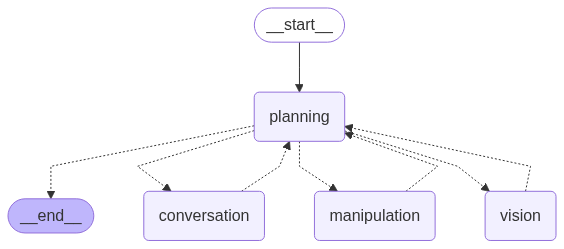

In [65]:
# 6.  BUILD THE GRAPH
# ────────────────────────────────────────────────────────────────

builder = StateGraph(AgentState)

builder.add_node("planning",     planner_node)
builder.add_node("vision",       make_specialist("vision",       VISION_PROMPT, VISION_TOOLS))
builder.add_node("manipulation", make_specialist("manipulation", MANIP_PROMPT,  MANIPULATION_TOOLS))
builder.add_node("conversation", make_specialist("conversation", CONV_PROMPT,   CONV_TOOLS))

builder.add_edge(START, "planning")  # the single required edge

graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [66]:
# 7.  QUICK MANUAL TEST
# ────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    user_msg = ("human", "Grab the banana")
    final = graph.invoke({"messages": [user_msg]}, debug=True)
    print(final["messages"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [('human', 'Grab the banana')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [('human', 'Grab the banana')]
[0:checkpoint] State at the end of step 0:
{'messages': [('human', 'Grab the banana')]}
[1:tasks] Starting 1 task for step 1:
- planning -> AgentState(messages=[('human', 'Grab the banana')],
           plan=[],
           current=None,
           results=[],
           n_executed=0)
llm reply: ```json
[
  {"agent": "vision", "command": "locate the banana", "parallel": false},
  {"agent": "manipulation", "command": "pick up the banana", "parallel": false}
]
```
executing next step: {'agent': 'vision', 'command': 'locate the banana', 'parallel': False}
[1:writes] Finished step 1 with writes to 3 channels:
- plan -> [{'agent': 'manipulation', 'command': 'pick up the banana', 'parallel': False}]
- messages -> [('human', 'Grab the banana'),
 AIMessag